## Replacing gather_nd

#### Lift batch_gather into our disparity gather

Plan:
- we are using batch gather instead of gather_nd

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from timeit import default_timer as timer

In [2]:
from test import *
home = Path.home() / 'deeval'
import sys; sys.path.append(str(home))
from evaluate import show_row
import emfnet.dataset_wheel_render as ds
from emfnet.bilinear_sampler import simple_sampler, linear_sampler


In [3]:
ds.BATCH, ds.cnt, ds.padd = 8, 1, 1
ds.H = 2056
dataset = ds.get_dataset(str(home / ds.folder), 'valid', fast_start=True)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
sess = tf.Session()

In [5]:
sess.run(dataset.initializer)
limg, rimg, ldisp = sess.run(dataset.get_next())

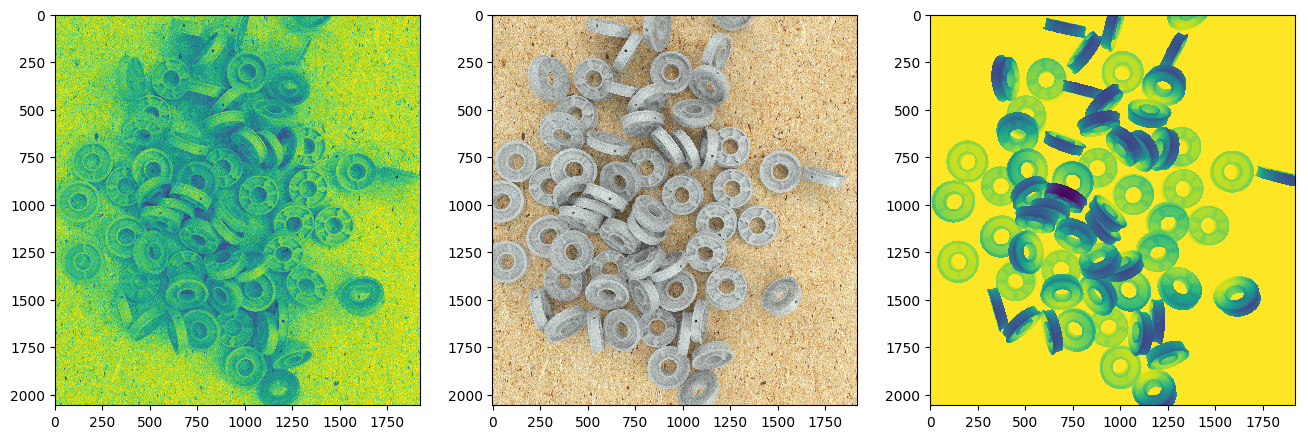

In [6]:
rldisp = np.round(ldisp)
show_row(limg[0,...,0], rimg[0], rldisp[0,...,0])

In [7]:
td = tf.cast(tf.convert_to_tensor(rldisp), tf.int32)
tr = tf.convert_to_tensor(limg)
shape = rldisp.shape
shape

(8, 2056, 1920, 1)

In [8]:
# from emfnet.bilinear_sampler import linear_sampler
# linear_sampler._get_grid_array(shape[0], shape[1], shape[2], tf.)

In [9]:
rtd = tf.reshape(td + tf.cast(tf.reshape(tf.range(tf.constant(1920)), (-1, 1920, 1)), td.dtype), (-1, 2056, 1920))
rtr = tr[...]
rtd.shape, rtr.shape

(TensorShape([Dimension(8), Dimension(2056), Dimension(1920)]),
 TensorShape([Dimension(8), Dimension(2056), Dimension(1920), Dimension(3)]))

In [10]:
sess.run(tf.batch_gather(tf.constant([[[1,1],[2,2],[3,3],[4,4],[5,5],[6,6]]]), tf.constant([[0,0,3,3,4,4,2]])))

array([[[1, 1],
        [1, 1],
        [4, 4],
        [4, 4],
        [5, 5],
        [5, 5],
        [3, 3]]], dtype=int32)

In [11]:
start = timer()
warped = sess.run(tf.batch_gather(rtr, rtd))
print(rtr.shape, rtd.shape, warped.shape)
print(f'New method time: {timer()-start}')
# show_row(warped[0], dpi=30)

(8, 2056, 1920, 3) (8, 2056, 1920) (8, 2056, 1920, 3)
New method time: 32.00139363999915


In [12]:
start2 = timer()
warped_ours = sess.run(linear_sampler(tr, tf.cast(td, tf.float32), out='EDGE'))
print(f'Old metchod time: {timer()-start2}')
# show_row(warped_ours[0], dpi=30)

Old metchod time: 40.41478069200093
